<a href="https://colab.research.google.com/github/sobhanshukueian/U-Net-Semantic-Segmentation/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Semantic Segmentation

U-net is a semantic segmentation model architecture that developed by Olaf Ronneberger et al, for bio medical images like paper's name that mentioned this.
Below you can see the architecture of model, it contains two main parts encoder and decoder.


*   Encoder Extracts features from input data (images) and transfer it to a latent space which has lower dimensions than the inputs. It contains traditional convolutional and pooling layers.
*   Decoder performs reconstruction with the latent space representations

The U-Net is an elegant architecture that solves most of the occurring issues. It uses the concept of fully convolutional networks for this approach. The intent of the U-Net is to capture both the features of the context as well as the localization. This process is completed successfully by the type of architecture built.


[Paper Link](https://arxiv.org/abs/1505.04597v1)

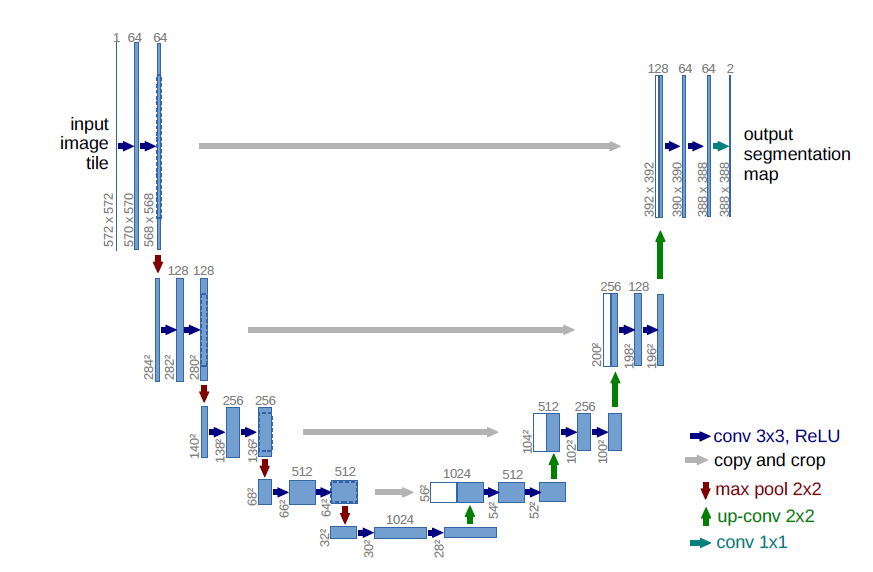


We notice skip-connections that connect the previous outputs with the layers in the decoder blocks.
This skip connection is a vital concept to preserve the loss from the previous layers so that they reflect stronger on the overall values. They are also scientifically proven to produce better results and lead to faster model convergence. In the final convolution block, we have a couple of convolutional layers followed by the last convolution layer. This layer has a filter of 2 with the appropriate function to display the resulting output. This final layer can be changed according to the desired purpose of the project you are trying to perform.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#CamVid Dataset
CamVid (Cambridge-driving Labeled Video Database) is a road/driving scene understanding database which was originally captured as five video sequences with a 960×720 resolution camera mounted on the dashboard of a car. Those sequences were sampled (four of them at 1 fps and one at 15 fps) adding up to 701 frames.
You Can Dowload dataset from kaggle:

[Download Dataset from Kaggle](https://www.kaggle.com/datasets/carlolepelaars/camvid)

## Some Configs for downloading from kaggle :

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download kaggle.json file on your machine.


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
#Upload the token json file
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11453        457  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3529        133  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            738         29  1.0              
j

In [ ]:
!kaggle datasets download -d carlolepelaars/camvid

 99% 569M/575M [00:12<00:00, 50.1MB/s]
100% 575M/575M [00:12<00:00, 47.8MB/s]


In [ ]:
!unzip "camvid.zip"

Archive:  camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_007290.pn


#Import Dependencies and Configurations

In [ ]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import shutil
import glob
import albumentations
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [ ]:
DATASET_PATH = "/content/CamVid" #@param
train_images = glob.glob(f"{DATASET_PATH}/train/*")
train_images.sort()
train_segs = glob.glob(f"{DATASET_PATH}/train_labels/*")
train_segs.sort()
valid_images = glob.glob(f"{DATASET_PATH}/val/*")
valid_images.sort()
valid_segs = glob.glob(f"{DATASET_PATH}/val_labels/*")
valid_segs.sort()

In [ ]:
# all the classes that are present in the dataset
CLASSES = ['animal', 'archway', 'bicyclist', 'bridge', 'building', 'car',
        'cartluggagepram', 'child', 'columnpole', 'fence', 'lanemarkingdrve',
        'lanemarkingnondrve', 'misctext', 'motorcyclescooter', 'othermoving',
        'parkingblock', 'pedestrian', 'road', 'road shoulder', 'sidewalk',
        'signsymbol', 'sky', 'suvpickuptruck', 'trafficcone', 'trafficlight',
        'train', 'tree', 'truckbase', 'tunnel', 'vegetationmisc', 'void',
        'wall']

label_colors_list = [
        (64, 128, 64), # animal
        (192, 0, 128), # archway
        (0, 128, 192), # bicyclist
        (0, 128, 64), #bridge
        (128, 0, 0), # building
        (64, 0, 128), #car
        (64, 0, 192), # car luggage pram...???...
        (192, 128, 64), # child
        (192, 192, 128), # column pole
        (64, 64, 128), # fence
        (128, 0, 192), # lane marking driving
        (192, 0, 64), # lane maring non driving
        (128, 128, 64), # misc text
        (192, 0, 192), # motor cycle scooter
        (128, 64, 64), # other moving
        (64, 192, 128), # parking block
        (64, 64, 0), # pedestrian
        (128, 64, 128), # road
        (128, 128, 192), # road shoulder
        (0, 0, 192), # sidewalk
        (192, 128, 128), # sign symbol
        (128, 128, 128), # sky
        (64, 128, 192), # suv pickup truck
        (0, 0, 64), # traffic cone
        (0, 64, 64), # traffic light
        (192, 64, 128), # train
        (128, 128, 0), # tree
        (192, 128, 192), # truck/bus
        (64, 0, 64), # tunnel
        (192, 192, 0), # vegetation misc.
        (0, 0, 0),  # 0=background/void
        (64, 192, 0), # wall
    ]

# DataSet and DataLoader
Load Images then apply normalization and resize images to size 224*224

In [ ]:
def get_label_mask(mask, class_values):
    """
    This function encodes the pixels belonging to the same class
    in the image into the same label
    """
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for value in class_values:
        for ii, label in enumerate(label_colors_list):
            if value == label_colors_list.index(label):
                label = np.array(label)
                label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask


In [ ]:
class CamVidDataset(Dataset):
    CLASSES = CLASSES

    def __init__(self, path_images, path_segs, image_transform, mask_transform, label_colors_list, classes):
        print(f"TRAINING ON CLASSES: {classes}")

        self.path_images = path_images
        self.path_segs = path_segs
        self.label_colors_list = label_colors_list
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    def __len__(self):
        return len(self.path_images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.path_images[index]).convert('RGB'))
        mask = np.array(Image.open(self.path_segs[index]).convert('RGB'))

        image = self.image_transform(image=image)['image']
        mask = self.mask_transform(image=mask)['image']

        # get the colored mask labels
        mask = get_label_mask(mask, self.class_values)

        image = np.transpose(image, (2, 0, 1))

        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask



In [ ]:
# Dataset Transoframtions which apply in loading phase
train_image_transform = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
    albumentations.Normalize(
            always_apply=True)
])
valid_image_transform = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
    albumentations.Normalize(
            always_apply=True)
])
train_mask_transform = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
])
valid_mask_transform = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
])



In [ ]:
# Define train and validation datasets
train_dataset = CamVidDataset(train_images, train_segs, train_image_transform,
                              train_mask_transform,
                              label_colors_list,
                              classes=CLASSES)

valid_dataset = CamVidDataset(valid_images, valid_segs, valid_image_transform,
                              valid_mask_transform,
                              label_colors_list,
                              classes=CLASSES)


TRAINING ON CLASSES: ['animal', 'archway', 'bicyclist', 'bridge', 'building', 'car', 'cartluggagepram', 'child', 'columnpole', 'fence', 'lanemarkingdrve', 'lanemarkingnondrve', 'misctext', 'motorcyclescooter', 'othermoving', 'parkingblock', 'pedestrian', 'road', 'road shoulder', 'sidewalk', 'signsymbol', 'sky', 'suvpickuptruck', 'trafficcone', 'trafficlight', 'train', 'tree', 'truckbase', 'tunnel', 'vegetationmisc', 'void', 'wall']
TRAINING ON CLASSES: ['animal', 'archway', 'bicyclist', 'bridge', 'building', 'car', 'cartluggagepram', 'child', 'columnpole', 'fence', 'lanemarkingdrve', 'lanemarkingnondrve', 'misctext', 'motorcyclescooter', 'othermoving', 'parkingblock', 'pedestrian', 'road', 'road shoulder', 'sidewalk', 'signsymbol', 'sky', 'suvpickuptruck', 'trafficcone', 'trafficlight', 'train', 'tree', 'truckbase', 'tunnel', 'vegetationmisc', 'void', 'wall']


In [ ]:
BATCH_SIZE = 16 #@param

In [ ]:
# Define dataloader using pytorch default dataloader
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Load a batch from dataset to plot it
iteration = iter(valid_data_loader)
vis_batch = next(iteration)
vis_batch[0].shape, vis_batch[1].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 224, 224]))

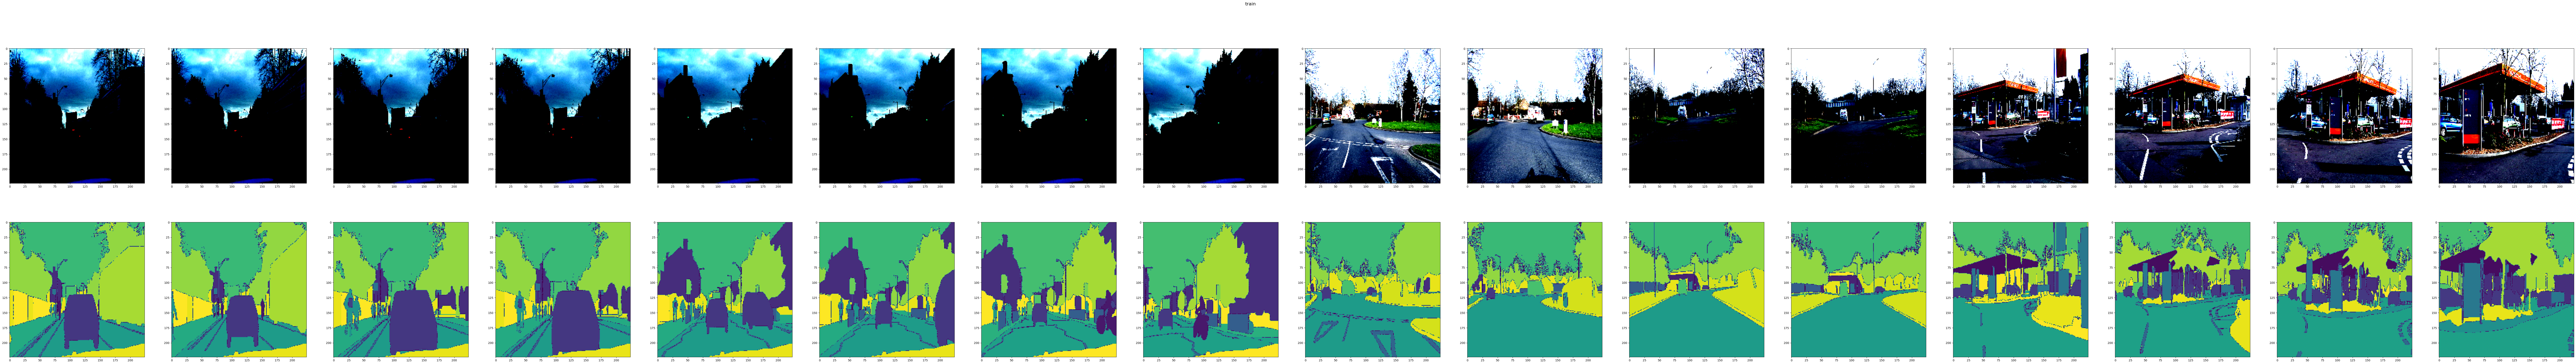

In [ ]:
# PLOT a batch from validation dataloader
def plot_images(data, labels, name="train", cols = 16):
    fig, ax = plt.subplots(2, cols, figsize=(cols*10, 2*10))
    fig.suptitle(name, fontsize=16)
    for index in range(cols):
        ax[0, index].imshow(np.clip(data[index].permute(1, 2, 0).numpy(), 0, 1))
        ax[1, index].imshow(labels[index])

    plt.show()
plot_images(vis_batch[0], vis_batch[1])

# U-Net Model Architecture

U-Net Model that uses VGG pretrained network for feature extraction and have skip connections in the upsampling stage.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        # print("Double Conv ==== >", x.size())
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvNet(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        # print("Down ==== >", x.size())
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvNet(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        x2 = torchvision.transforms.CenterCrop([x1.size(2), x1.size(3)])(x2)
        x = torch.cat([x2, x1], dim=1)
        # print("Up ==== >", x.size())
        x = self.conv(x)
        # print("Up ==== >", x.size())
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = ConvNet(3, 64)
        self.down1 = DownConv(64, 128)
        self.down2 = DownConv(128, 256)
        self.down3 = DownConv(256, 512)
        self.down4 = DownConv(512, 1024)

        self.up1 = UpConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.outc = nn.Conv2d(64, len(CLASSES), 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # print("Finished Encoder ------------")
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

test_data = torch.rand((16, 3, 224, 224))
net = UNet()
print(test_data.size())
out = net(test_data)

torch.Size([16, 3, 224, 224])


## FPN Model Architecture

The FPN (Feature Pyramid Network) semantic segmentation model is a deep learning architecture commonly used for pixel-wise image segmentation tasks. It was introduced by Lin et al. in their [paper](https://arxiv.org/abs/1901.02446) "Feature Pyramid Networks for Object Detection" in 2017.

The main idea behind FPN is to address the challenge of object segmentation at different scales in an image. It aims to capture both fine-grained details and high-level context information to improve the accuracy of segmentation.

FPN incorporates a top-down pathway and a lateral connection pathway. The top-down pathway involves progressively downsampling the input image to generate a feature pyramid with multiple scales. The lateral connection pathway connects feature maps from different scales to ensure the fusion of information across different levels.

The FPN model utilizes a backbone network, such as ResNet or VGG, to extract features from the input image. These features are then passed through the top-down and lateral connection pathways to generate a set of feature maps at different scales. These feature maps are combined to form a feature pyramid, which is then fed into a segmentation head to predict pixel-wise class labels or masks.

By leveraging the multi-scale feature pyramid, the FPN model can effectively handle objects of various sizes and capture both local and global context information. This makes it particularly suitable for tasks like semantic segmentation, where accurate object delineation is crucial.

Overall, the FPN semantic segmentation model has been widely adopted and achieved state-of-the-art performance on various benchmark datasets, demonstrating its effectiveness in tackling pixel-wise segmentation tasks.

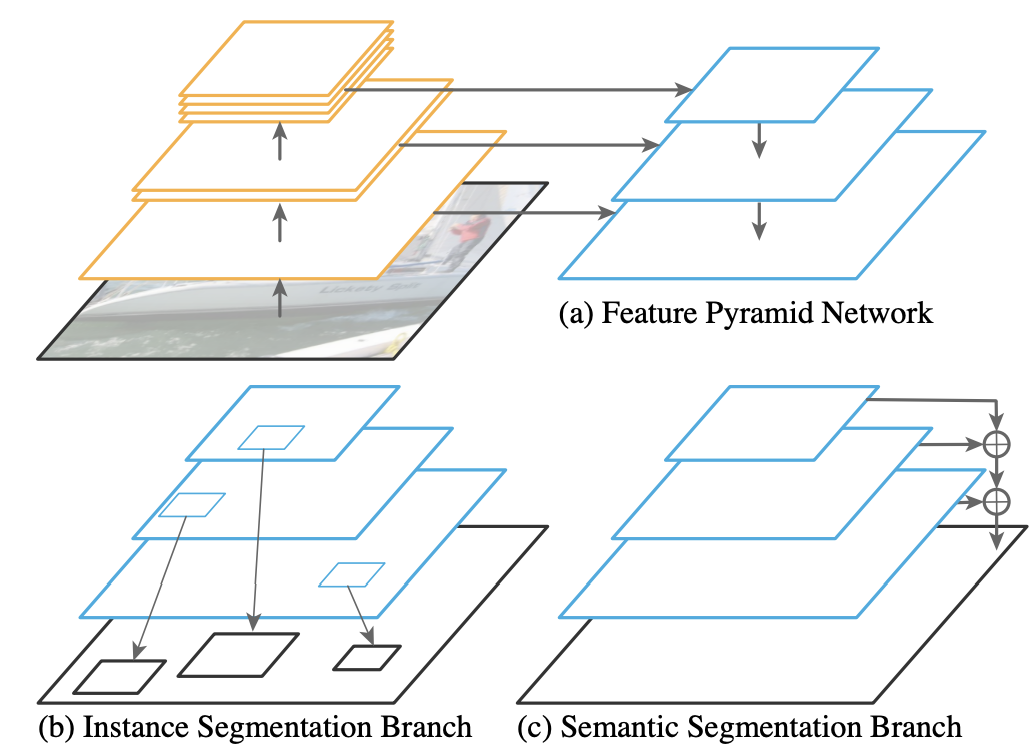

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class FPN(nn.Module):
    def __init__(self, num_classes):
        super(FPN, self).__init__()
         # Load the backbone model (e.g., ResNet50)
        self.backbone = models.resnet50(pretrained=True)
         # Feature pyramid network
        self.pyramid_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.Conv2d(2048, 256, kernel_size=1)
        ])
        self.smoothing_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        ])
        self.predictor = nn.Conv2d(256, num_classes, kernel_size=3, padding=1)
    def forward(self, x):
        # Backbone feature extraction
        features = self.backbone.conv1(x)
        features = self.backbone.bn1(features)
        features = self.backbone.relu(features)
        features = self.backbone.maxpool(features)
        c2 = self.backbone.layer1(features)
        c3 = self.backbone.layer2(c2)
        c4 = self.backbone.layer3(c3)
        c5 = self.backbone.layer4(c4)
         # Feature pyramid network
        p5 = self.pyramid_layers[3](c5)
        p4 = self.smoothing_layers[2](self.pyramid_layers[2](c4) + nn.functional.interpolate(p5, scale_factor=2, mode='nearest'))
        p3 = self.smoothing_layers[1](self.pyramid_layers[1](c3) + nn.functional.interpolate(p4, scale_factor=2, mode='nearest'))
        p2 = self.smoothing_layers[0](self.pyramid_layers[0](c2) + nn.functional.interpolate(p3, scale_factor=2, mode='nearest'))
         # Final prediction
        output = self.predictor(p2)
        return output

# PSP-Net Model Architecture
PSPNet (Pyramid Scene Parsing Network) is a deep learning model designed for semantic segmentation tasks. It was introduced by Zhao et al. in their [paper](https://arxiv.org/abs/1612.01105) "Pyramid Scene Parsing Network" in 2017.

The main objective of PSPNet is to capture contextual information at different scales to improve the accuracy of semantic segmentation. It achieves this by employing a pyramid pooling module that aggregates features from multiple scales.

PSPNet starts with a backbone network, such as ResNet or VGG, to extract high-level features from the input image. These features are then passed through a pyramid pooling module, which divides the feature map into different regions and performs spatial pooling at multiple scales. This allows the model to capture both local and global context information.

The pooled features from the pyramid pooling module are then upsampled and concatenated to form a fused feature representation. This fused representation is further processed by convolutional layers to refine the features and generate the final pixel-wise class predictions.

One of the key advantages of PSPNet is its ability to effectively capture context information across different scales without significantly increasing the computational complexity. By incorporating the pyramid pooling module, PSPNet can handle objects of various sizes and capture both fine-grained details and high-level context.

PSPNet has achieved state-of-the-art performance on various benchmark datasets for semantic segmentation, demonstrating its effectiveness in accurately segmenting objects in images.

It's worth noting that PSPNet was originally proposed for the English language, but it can be adapted and trained for other languages as well, given the availability of annotated datasets in those languages.

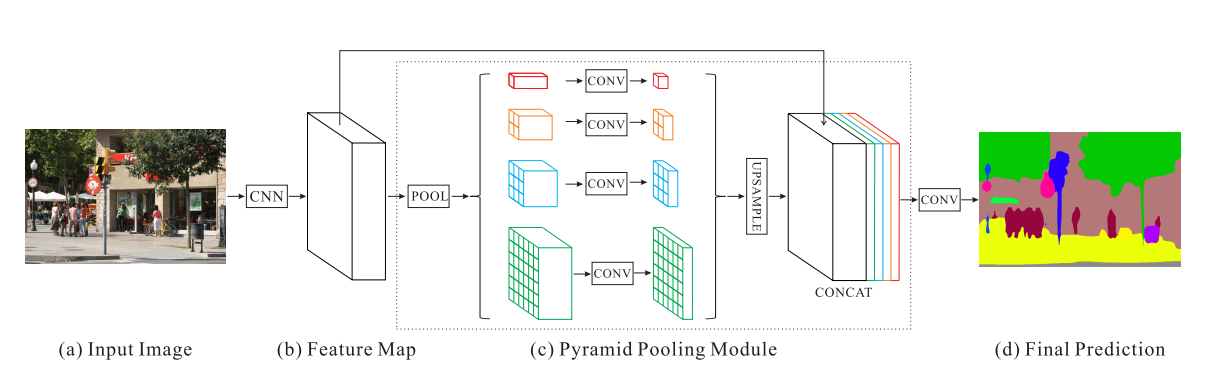

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PSPNet(nn.Module):
	def __init__(self, n_classes):
		super().__init__()

		block_config = [3, 4, 6, 3]  # resnet50
		img_size = 224
		img_size_8 = 56  # img_size to 1/8

		# 4 module for subnetwork
		self.feature_conv = FeatureMap_convolution()

		self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
			6, 3, 2, 1], height=img_size_8, width=img_size_8)

		self.decode_feature = DecodePSPFeature(
			height=img_size, width=img_size, n_classes=n_classes)

		self.aux = AuxiliaryPSPlayers(
			in_channels=2048, height=img_size, width=img_size, n_classes=n_classes)

	def forward(self, x):
		x = self.feature_conv(x)

		output_aux = self.aux(x)  #  a part of Feature module into Aux module


		x = self.pyramid_pooling(x)
		output = self.decode_feature(x)

		return (output, output_aux)

class conv2DBatchNormRelu(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
		super().__init__()
		self.conv = nn.Conv2d(in_channels, out_channels,
							  kernel_size, stride, padding, dilation, bias=bias)
		self.batchnorm = nn.BatchNorm2d(out_channels)
		self.relu = nn.ReLU(inplace=True)
		# inplace=True, decrease memory consumption by not preserving input

	def forward(self, x):
		x = self.conv(x)
		x = self.batchnorm(x)
		outputs = self.relu(x)

		return outputs

class FeatureMap_convolution(nn.Module):
        def __init__(self):
                super().__init__()

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
                self.cbnr_1 = conv2DBatchNormRelu(
                  in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
                self.cbnr_2 = conv2DBatchNormRelu(
                  in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
                self.cbnr_3 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 128, 256, 3, 1, 1, 1, False
                self.cbnr_4 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 256, 512, 3, 1, 1, 1, False
                self.cbnr_5 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 512, 1024, 3, 1, 1, 1, False
                self.cbnr_6 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 1024, 2048, 3, 1, 1, 1, False
                self.cbnr_7 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

                self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)



        def forward(self, x):
                x = self.cbnr_1(x)
                x = self.cbnr_2(x)
                x = self.cbnr_3(x)
                x = self.cbnr_4(x)
                x = self.cbnr_5(x)
                x = self.cbnr_6(x)
                x = self.cbnr_7(x)
                outputs = self.maxpool(x)
                return outputs



class conv2DBatchNorm(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
		super().__init__()
		self.conv = nn.Conv2d(in_channels, out_channels,
							  kernel_size, stride, padding, dilation, bias=bias)
		self.batchnorm = nn.BatchNorm2d(out_channels)

	def forward(self, x):
		x = self.conv(x)
		outputs = self.batchnorm(x)

		return outputs



class PyramidPooling(nn.Module):
	def __init__(self, in_channels, pool_sizes, height, width):
		super().__init__()

		self.height = height
		self.width = width

		out_channels = int(in_channels / len(pool_sizes))

		# pool_sizes: [6, 3, 2, 1]
		self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
		self.cbr_1 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
		self.cbr_2 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
		self.cbr_3 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

		self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
		self.cbr_4 = conv2DBatchNormRelu(
			in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

	def forward(self, x):

		out1 = self.cbr_1(self.avpool_1(x))
		out1 = F.interpolate(out1, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out2 = self.cbr_2(self.avpool_2(x))
		out2 = F.interpolate(out2, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out3 = self.cbr_3(self.avpool_3(x))
		out3 = F.interpolate(out3, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		out4 = self.cbr_4(self.avpool_4(x))
		out4 = F.interpolate(out4, size=(
			self.height, self.width), mode="bilinear", align_corners=True)

		if (x.size(2) != out1.size(2) or out1.size(2) != out2.size(2)):
			print(x.size(), out1.size(), out2.size(), out3.size(), out4.size())

		output = torch.cat([x, out1, out2, out3, out4], dim=1)

		return output

class DecodePSPFeature(nn.Module):
	def __init__(self, height, width, n_classes):
		super().__init__()

		self.height = height
		self.width = width

		self.cbr = conv2DBatchNormRelu(
			in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
		self.dropout = nn.Dropout2d(p=0.1)
		self.classification = nn.Conv2d(
			in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

	def forward(self, x):
		x = self.cbr(x)
		x = self.dropout(x)
		x = self.classification(x)
		output = F.interpolate(
			x, size=(self.height, self.width), mode="bilinear", align_corners=True)
		return output

class AuxiliaryPSPlayers(nn.Module):
	def __init__(self, in_channels, height, width, n_classes):
		super().__init__()

		self.height = height
		self.width = width

		self.cbr = conv2DBatchNormRelu(
			in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
		self.dropout = nn.Dropout2d(p=0.1)
		self.classification = nn.Conv2d(
			in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

	def forward(self, x):
		x = self.cbr(x)
		x = self.dropout(x)
		x = self.classification(x)
		output = F.interpolate(
			x, size=(self.height, self.width), mode="bilinear", align_corners=True)
		return output

# Trainer Class
This class Does the main part of code which is training model, plot the training process and save model each n epochs.

I Defined `CrossEntropy` Loss and `Adam` Optimizer with learning rate 0.001 and 0.999 momentum.

Dp Each training step in `train_step` function and validation step in `val_step` function and whole trining process in
`train` function.

### ⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇ U can See other Configurations BELOW ⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇

In [ ]:
#@title Some Configurations
EPOCHS = 200 #@param {type:"integer"}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 0 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "/content/drive/MyDrive/unet semantic/runs" #@param
MODEL_NAME = "PSPNet Semantic Segmentation" #@param
WEIGHTS = None


In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from sklearn.metrics import auc

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class PSPLoss(nn.Module):
	def __init__(self, aux_weight=0.4):
		super().__init__()
		self.aux_weight = aux_weight

	def forward(self, outputs, gts):
		"""
		Args
		outputs : output of PSPNet (tuple)
			(output=torch.Size([batch, n_classes, 475, 475]),
			output_aux=torch.Size([batch, n_classes, 475, 475]))

		gts : ground truth [batch, 475, 475]

		Returns
		loss : torch tensor
		"""
		loss = F.cross_entropy(outputs[0], gts, reduction='mean')
		loss_aux = F.cross_entropy(outputs[1], gts, reduction='mean')
		return loss + self.aux_weight * loss_aux





class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=10, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_data_loader, valid_loader=valid_data_loader, weights=WEIGHTS, verbose=VERBOSE, visualize_plots=VISUALIZE_PLOTS, save_plots=SAVE_PLOTS, model_name=MODEL_NAME, classes=CLASSES):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = model_name
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose

        self.train_losses=[]
        self.val_losses=[]
        self.train_ious = []
        self.val_ious=[]
        self.train_accs = []
        self.val_accs=[]

        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}
        self.classes = classes

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
            print(tmp_save_dir)
        self.save_dir = tmp_save_dir
        os.makedirs(self.save_dir)
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum

        # get model
        self.model = self.get_model(self.model_name)
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()

        # tensorboard
        # self.tblogger = SummaryWriter(self.save_dir)

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model
    def get_model(self, model_name):
        # Get Model Archutecture From Model Class.

        if model_name == 'UNet':
          model = UNet().to(self.device)

        if model_name == 'FPN':
          model = FPN(len(self.classes)).to(self.device)

        if model_name == 'PSPNet':
          model = PSPNet(len(self.classes)).to(self.device)


        # finetune if pretrained model is set
        if self.weights:
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    def get_optimizer(self, optimizer="Adam", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(self.model.parameters(), lr=lr0, betas=(momentum, 0.999))

        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, images, targets):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(images, targets)
        return loss

    def compute_PSPNet_loss(self, outputs, gts, alpha):
      #PSPSNet_loss = PSPLoss(alpha)
      loss = PSPLoss(alpha).forward(outputs, gts)
      return loss


    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images = batch_data[0].to(device)
        targets = batch_data[1].to(device)
        return images, targets

    # Each Train Step
    def train_step(self, batch_data):
        images, targets = self.prepro_data(batch_data, self.device)
        # forward

        if self.model_name == 'PSPNet':
          outputs = self.model(images)
          loss = self.compute_PSPNet_loss(outputs, targets)
        else:
          with amp.autocast(enabled=self.device != 'cpu'):
              preds = self.model(images)
              # preds = preds['out']
              loss = self.compute_loss(preds, targets)
          l2_lambda = 0.001
          l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())

          loss = loss + l2_lambda * l2_norm
        # backward
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        _, predictions = torch.max(preds.data, 1)
        return loss.detach().cpu().numpy(), predictions.detach().cpu().numpy(), targets.detach().cpu().numpy()

    # Each Validation Step
    def val_step(self, batch_data):
        self.model.eval()
        images, targets = self.prepro_data(batch_data, self.device)


        if self.model_name == 'PSPNet':
          outputs = self.model(images)
          loss = self.compute_PSPNet_loss(outputs, targets)
        else:
          # forward
          preds = self.model(images)
          # preds = preds['out']
          loss = self.compute_loss(preds, targets)
          _, predictions = torch.max(preds.data, 1)
        return loss.detach().cpu().numpy(), predictions.detach().cpu().numpy(), targets.detach().cpu().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf
            print("---\t\tEPOCH\tLoss\tIOU\tAccuracy")

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    print("---------------------------------------")
                    self.conf["Trained_epoch"] = self.epoch
                    train_losses = []
                    val_losses = []
                    train_ious = []
                    val_ious = []
                    train_accs = []
                    val_accs = []

                    # Training loop
                    self.model.train(True)
                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    for step, batch_data in pbar:
                        if step == self.max_stepnum - 2 :
                            self.train_loss, preds, targets = self.train_step(batch_data)
                            iou , acc = self.evaluation(preds, targets)
                        else :
                            self.train_loss, predss, targetss = self.train_step(batch_data)
                            iou , acc = self.evaluation(predss, targetss)


                        # print("\nself.train_loss", self.train_loss)
                        # print("\niou", iou)
                        # print("\nacc", acc)
                        self.train_losses.append(self.train_loss)
                        self.train_ious.append(iou)
                        self.train_accs.append(acc)

                        train_losses.append(self.train_loss)
                        train_ious.append(iou)
                        train_accs.append(acc)
                        pbar.set_description("Train\t\t%.0f/%.0f\t%.3f\t%.3f\t%.3f\t\t" % (self.epoch, self.epochs, np.mean(train_losses), np.mean(train_ious), np.mean(train_accs)))
                    del pbar

                    # Validation Loop
                    vbar = enumerate(self.valid_loader)
                    vbar = tqdm(vbar, total=len(self.valid_loader))
                    for step, batch_data in vbar:
                        if step == 0 :
                            self.val_loss, val_preds, val_targets = self.val_step(batch_data)
                            val_iou , val_acc = self.evaluation(val_preds, val_targets)
                        else :
                            self.val_loss, val_predss, val_targetss = self.val_step(batch_data)
                            val_iou , val_acc = self.evaluation(val_predss, val_targetss)


                        self.val_losses.append(self.val_loss)
                        self.val_ious.append(val_iou)
                        self.val_accs.append(val_acc)

                        val_losses.append(self.val_loss)
                        val_ious.append(val_iou)
                        val_accs.append(val_acc)
                        vbar.set_description("Validation\t%.0f/%.0f\t%.3f\t%.3f\t%.3f\t\t" % (self.epoch, self.epochs, np.mean(val_losses), np.mean(val_ious), np.mean(val_accs)))
                    del vbar

                    if (self.epoch+1) % 10 == 0:
                        # PLot Losses
                        self.plot_loss()
                        self.plot_images(preds, targets, "train")
                        self.plot_images(val_preds, val_targets, "val")
                        print("\n---\t\tEPOCH\tLoss\tIOU\tAccuracy")


                    if self.val_loss < self.best_loss:
                        self.best_loss=self.val_loss

                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.')


    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=3
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle("Losses Plot", fontsize=16)

        # train_mean_size = self.max_stepnum/self.batch_size
        ax[0][0].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0][0].set_title("Training Loss")

        val_mean_size = len(self.valid_loader)
        ax[0][1].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[0][1].set_title("Validation Loss")

        train_mean_size = self.max_stepnum
        ax[0][2].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0][2].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[0][2].set_title("Train Validation Loss")


        # train_mean_size = self.max_stepnum/self.batch_size
        ax[1][0].plot(np.arange(len(self.train_ious) / train_mean_size), np.mean(np.array(self.train_ious).reshape(-1, train_mean_size), axis=1), 'r',  label="training IOU", linewidth=LINE_WIDTH)
        ax[1][0].set_title("Training IOU")

        val_mean_size = len(self.valid_loader)
        ax[1][1].plot(np.arange(len(self.val_ious) / val_mean_size), np.mean(np.array(self.val_ious).reshape(-1, val_mean_size), axis=1), 'g',  label="validation IOU", linewidth=LINE_WIDTH)
        ax[1][1].set_title("Validation IOU")

        train_mean_size = self.max_stepnum
        ax[1][2].plot(np.arange(len(self.train_ious) / train_mean_size), np.mean(np.array(self.train_ious).reshape(-1, train_mean_size), axis=1), 'r',  label="training IOU", linewidth=LINE_WIDTH)
        ax[1][2].plot(np.arange(len(self.val_ious) / val_mean_size), np.mean(np.array(self.val_ious).reshape(-1, val_mean_size), axis=1), 'g',  label="validation IOU", linewidth=LINE_WIDTH)
        ax[1][2].set_title("Train Validation IOU")

            # train_mean_size = self.max_stepnum/self.batch_size
        ax[2][0].plot(np.arange(len(self.train_accs) / train_mean_size), np.mean(np.array(self.train_accs).reshape(-1, train_mean_size), axis=1), 'r',  label="training Accuracy", linewidth=LINE_WIDTH)
        ax[2][0].set_title("Training Accuracy")

        val_mean_size = len(self.valid_loader)
        ax[2][1].plot(np.arange(len(self.val_accs) / val_mean_size), np.mean(np.array(self.val_accs).reshape(-1, val_mean_size), axis=1), 'g',  label="validation Accuracy", linewidth=LINE_WIDTH)
        ax[2][1].set_title("Validation Accuracy")

        train_mean_size = self.max_stepnum
        ax[2][2].plot(np.arange(len(self.train_accs) / train_mean_size), np.mean(np.array(self.train_accs).reshape(-1, train_mean_size), axis=1), 'r',  label="training Accuracy", linewidth=LINE_WIDTH)
        ax[2][2].plot(np.arange(len(self.val_accs) / val_mean_size), np.mean(np.array(self.val_accs).reshape(-1, val_mean_size), axis=1), 'g',  label="validation Accuracy", linewidth=LINE_WIDTH)
        ax[2][2].set_title("Train Validation Accuracy")

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots')
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch))
        if self.visualize_plots:
            plt.show()

    def plot_images(self, preds, targets, name="train", cols = 10):
        fig, ax = plt.subplots(2, cols, figsize=(cols*10, 2*10))
        fig.suptitle(name, fontsize=12)
        for index in range(cols):
            ax[0, index].imshow(preds[index])
            ax[1, index].imshow(targets[index])
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'images')
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-{}-image.png".format(save_plot_dir, self.epoch, name))
        if self.visualize_plots:
            plt.show()


    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json", "w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name, self.epoch))
            if osp.exists(best_filename):
                os.remove(best_filename)
            shutil.copyfile(filename, best_filename)

    # -------------------------------------------------------Evaluate Model-------------------------------------------
    def calc_iou(self, pred, target):
        ious = []
        for cls in range(len(self.classes)):
            pred_inds = pred == cls
            target_inds = target == cls
            intersection = pred_inds[target_inds].sum()
            union = pred_inds.sum() + target_inds.sum() - intersection
            if union == 0:
                continue
            else:
                ious.append(float(intersection) / max(union, 1))
        return np.mean(ious) * 100


    def calc_acc(self, pred, target):
        correct = (pred == target).sum()
        total   = (target == target).sum()
        return (correct / total) * 100

    def evaluation(self, pred, target):
        return self.calc_iou(pred, target), self.calc_acc(pred, target)


trainer = Trainer(batch_size=BATCH_SIZE, device=device, epochs=EPOCHS, verbose=VERBOSE, model_name = 'PSPNet').train()
# Trainer(batch_size=32, device="cpu", epochs=50, verbose=0, weights="/content/runs/weights/best_SSL_epoch_45.pt").run("/content/data/faces/testing/s5/2.pgm", "/content/data/faces/testing/s7/4.pgm")